# パラメータの初期値を変えながら、2層ニューラルネットワークで単純な回帰問題を解く

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.loss import mean_squared_error
from collections import OrderedDict
from common.layers import Affine, ReLU,MeanSquaredLoss, LeakyReLU
from common.optimizer import RMSProp, SGD

## 2層ニューラルネットワーククラス

In [9]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size,pini, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        np.random.seed(1111)
        
        # (1)パラメータの初期値を全て0にした場合
        self.params["W1"] = pini["W1"]
        self.params["b1"] = pini["b1"] 
        self.params["W2"] = pini["W2"]
        self.params["b2"] = pini["b2"] 

        
        # レイヤの生成
        self.layers = OrderedDict() # 順番付きdict形式.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] =  ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = MeanSquaredLoss() # 出力層
        
    def predict(self, x):
        """
        予測関数
        x : 入力
        """
        for layer in self.layers.values():
            # 入力されたxを更新していく = 順伝播計算
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, t):
        """
        損失関数
        x:入力データ, t:教師データ
        """
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        """
        精度
        """
        y = self.predict(x)
        return mean_squared_error(y, t)

        
    def gradient(self, x, t):
        """
        全パラメータの勾配を計算
        """
        
        # 順伝播
        self.loss(x, t)

        # 逆伝播
        dout = self.lastLayer.backward(dout=1) # 出力層
        
        ## doutを逆向きに伝える 
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # dW, dbをgradsにまとめる
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db    

        return grads
    

## データの生成

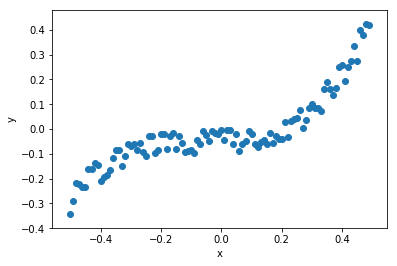

In [3]:
a = 3
b = 0.5
c = -0.1
x = np.arange(-0.5, 0.5, 0.01)
error = np.random.rand(x.size) * 0.1
y = a * x**3 + b * x**2 + c + error
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ミニバッチ学習

In [29]:
def run(x,y,pini):
    x = x.reshape(-1, 1)
    t = y.reshape(-1, 1)

    ecpochs = 5000
    batch_size = 25
    lr = 0.01

    # 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)

    # 2層NNのオブジェクト生成
    tnet = TwoLayerNet(input_size=1, hidden_size=10, output_size=1,pini=pini, weight_init_std=0.01)

    # 最適化手法
    optimizer = RMSProp(lr=lr, rho=0.9)
        
    # 初期パラメータの確認
    print("初期パラメータ")
    print(tnet.params["W1"].round(4))
    print(tnet.params["b1"].round(4))
    print(tnet.params["W2"].round(4))
    print(tnet.params["b2"].round(4))


    li_loss = []
    for epoch in range(ecpochs):
        
        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            mask = idx[batch_size*it : batch_size*(it+1)]
        
            # ミニバッチの生成
            x_train = x[mask]
            t_train = t[mask]
            
            # 勾配の計算 (誤差逆伝播法を用いる) 
            grads = tnet.gradient(x_train, t_train)

            # パラメータの更新
            optimizer.update(tnet.params, grads)

        # 学習経過の記録
        loss = tnet.loss(x, t)
        li_loss.append(loss)

    plot_loss(li_loss)
    plot_predict(tnet)
    plot_param(tnet)


### 学習結果の確認

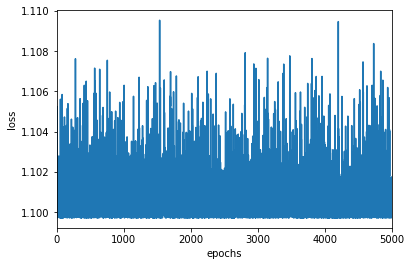

In [22]:
# lossのグラフ化
def plot_loss(li_loss):
    pd.DataFrame(li_loss).plot(legend=False)
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.show()

plot_loss(li_loss)

mse= 0.011017481126753974


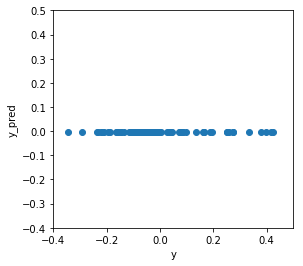

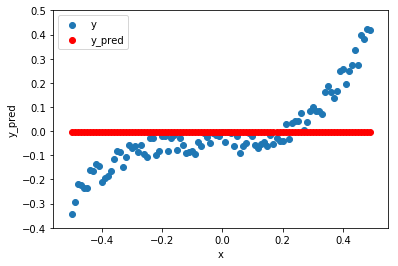

In [26]:
def plot_predict(tnet):
    # 訓練精度の確認
    y_pred = tnet.predict(x)
    print("mse=",mean_squared_error(y_pred, t))

    # 学習データと予測データの比較1
    plt.figure(figsize=(4.3,4))
    plt.scatter(y, y_pred)
    plt.xlabel("y")
    plt.ylabel("y_pred")
    plt.xlim([-0.4,0.5])
    plt.ylim([-0.4,0.5])
    plt.show()

    # 学習データと予測データの比較2
    plt.scatter(x, y)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(x, y_pred, c="r")
    plt.xlabel("x")
    plt.ylabel("y_pred")
    plt.legend(["y","y_pred"])
    plt.ylim([-0.4,0.5])
    plt.show()

plot_predict(tnet)

### パラメータの分布の確認

In [7]:
# 最終パラメータの確認
print(tnet.params["W1"].round(4))
print(tnet.params["b1"].round(4))
print(tnet.params["W2"].round(4))
print(tnet.params["b2"].round(4))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[-0.004]


最終パラメーター
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[-0.004]


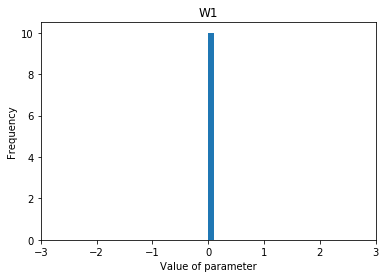

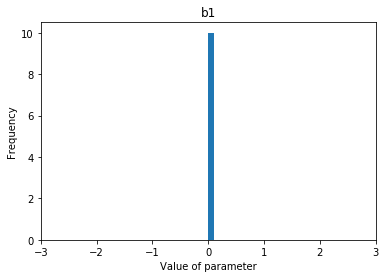

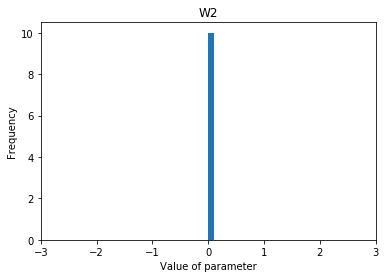

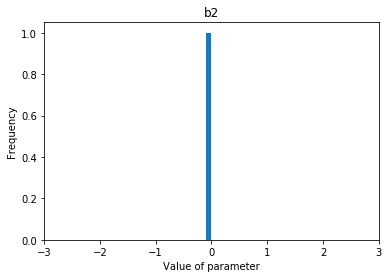

In [41]:
def plot_param(tnet):
    print("最終パラメーター")
    print(tnet.params["W1"].round(4))
    print(tnet.params["b1"].round(4))
    print(tnet.params["W2"].round(4))
    print(tnet.params["b2"].round(4))
    # パラメータ分布
    for key, value in tnet.params.items():
        plt.hist(value.flatten(), bins=10)
        plt.title(key)
        plt.xlim([-3, 3])
        plt.ylabel("Frequency")
        plt.xlabel("Value of parameter")
        plt.show()

plot_param(tnet)

### [演習]
* パラメータの初期値を以下のように設定し、結果を比較してみましょう
#### (1)パラメータの初期値を全て0にした場合
#### (2)Wの初期値を0にし、bの初期値を1にした場合
#### (3)パラメータの初期値を全て1にした場合
#### (4)パラメータの初期値を全て1にし、1つだけ1以外にした場合
#### (5)パラメータの初期値を正規分布にしたがってランダムにサンプリングした場合
#### (6)Wの初期値を正規分布にしたがってランダムにサンプリングし、bの初期値を0にした場合


### W=0, b=1

初期パラメータ
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[1.]


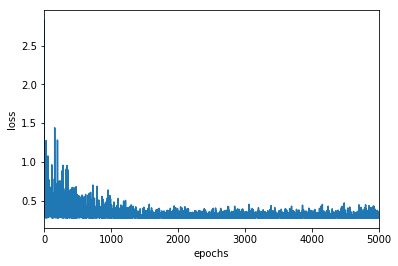

mse= 0.0027669141858400665


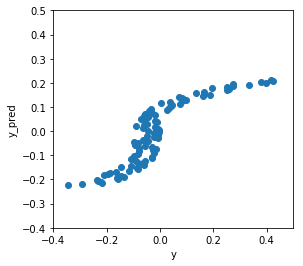

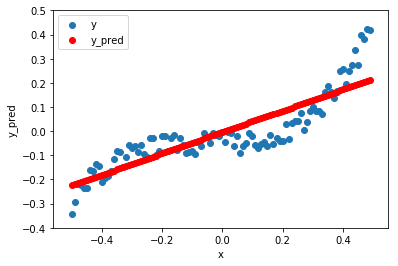

最終パラメーター
[[-0.2976 -0.2976 -0.2976 -0.2976 -0.2976 -0.2976 -0.2976 -0.2976 -0.2976
  -0.2976]]
[0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148 0.148]
[[-0.1485]
 [-0.1485]
 [-0.1485]
 [-0.1485]
 [-0.1485]
 [-0.1485]
 [-0.1485]
 [-0.1485]
 [-0.1485]
 [-0.1485]]
[0.2159]


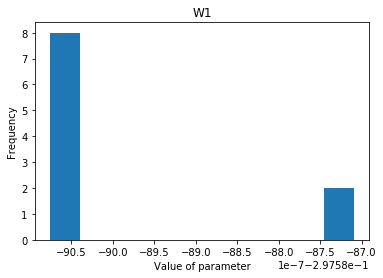

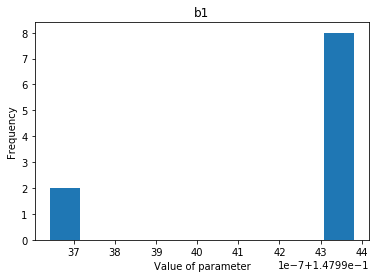

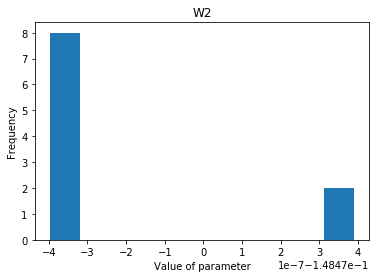

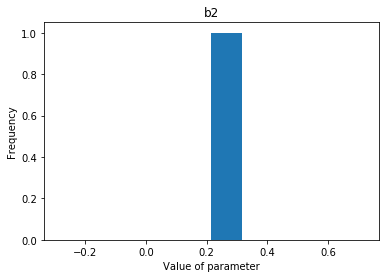

In [37]:
pram_ini ={
    "W1":np.zeros((1,10)),
    "W2":np.zeros((10,1)),
    "b1":np.ones(10),
    "b2":np.ones(1),
}

run(x,y,pram_ini)

初期パラメータ
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[1.]


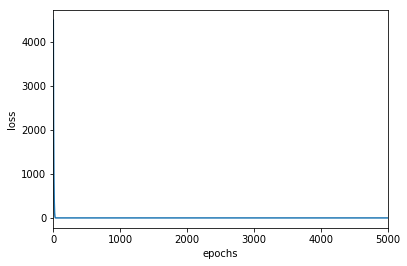

mse= 0.002801326088394229


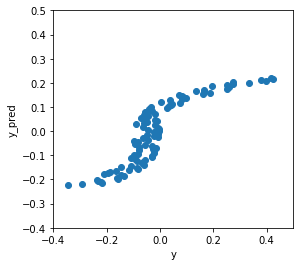

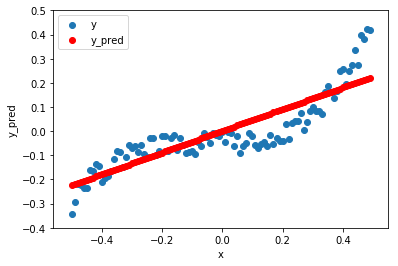

最終パラメーター
[[0.2836 0.2836 0.2836 0.2836 0.2836 0.2836 0.2836 0.2836 0.2834 0.2834]]
[0.1426 0.1426 0.1426 0.1426 0.1426 0.1426 0.1426 0.1426 0.1431 0.1431]
[[0.1583]
 [0.1583]
 [0.1583]
 [0.1583]
 [0.1583]
 [0.1583]
 [0.1583]
 [0.1583]
 [0.1585]
 [0.1585]]
[-0.2248]


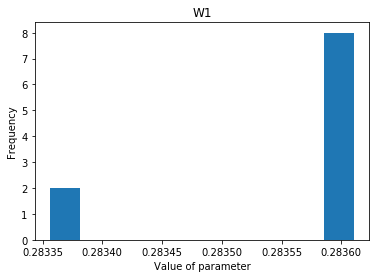

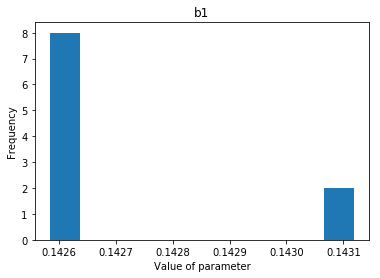

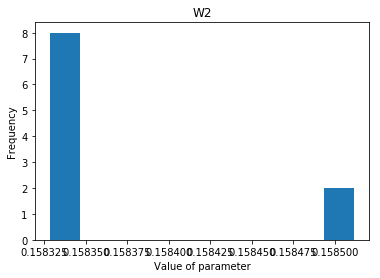

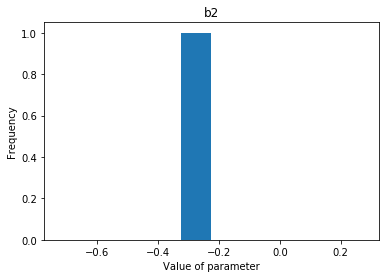

In [38]:
pram_ini ={
    "W1":np.ones((1,10)),
    "W2":np.ones((10,1)),
    "b1":np.ones(10),
    "b2":np.ones(1),
}

run(x,y,pram_ini)

初期パラメータ
[[ 1.   1.  -1.5  1.   1.   1.   1.   1.   1.   1. ]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[1.]


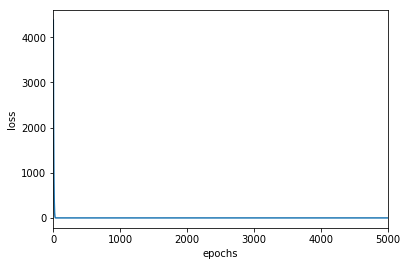

mse= 0.0024123157937661842


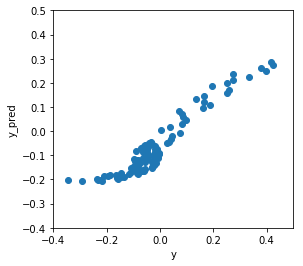

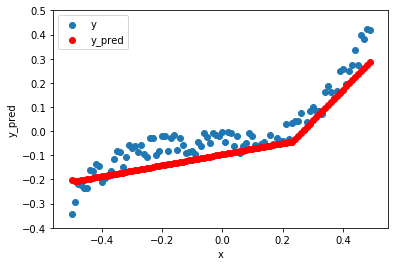

最終パラメーター
[[ 0.5407  0.5407 -1.9193  0.5407  0.5407  0.5407  0.5407  0.5407  0.5407
   0.5407]]
[0.2664 0.2664 0.4451 0.2664 0.2664 0.2664 0.2664 0.2664 0.2664 0.2664]
[[0.2636]
 [0.2636]
 [0.5496]
 [0.2636]
 [0.2636]
 [0.2636]
 [0.2636]
 [0.2636]
 [0.2636]
 [0.2636]]
[-0.9725]


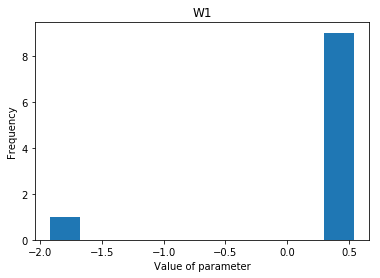

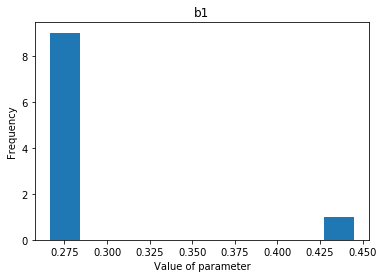

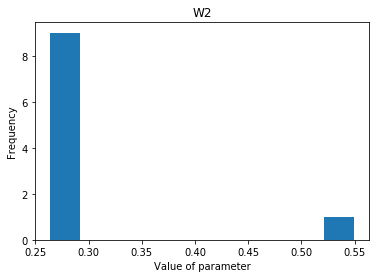

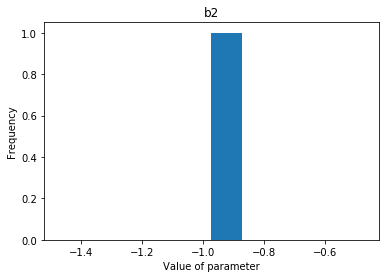

In [39]:
pram_ini ={
    "W1":np.ones((1,10)),
    "W2":np.ones((10,1)),
    "b1":np.ones(10),
    "b2":np.ones(1),
}

pram_ini["W1"][0,2]=-1.5

run(x,y,pram_ini)

初期パラメータ
[[-0.013  -0.0107  0.0079 -0.0088  0.015  -0.0002  0.0028 -0.0097 -0.0158
  -0.002 ]]
[ 0.0086 -0.0032 -0.0114 -0.0077  0.0033 -0.0096  0.0006  0.0042 -0.0008
 -0.0049]
[[-0.0098]
 [ 0.0187]
 [-0.0004]
 [-0.0144]
 [-0.0015]
 [-0.0111]
 [-0.0137]
 [ 0.001 ]
 [-0.0041]
 [-0.0089]]
[-0.0062]


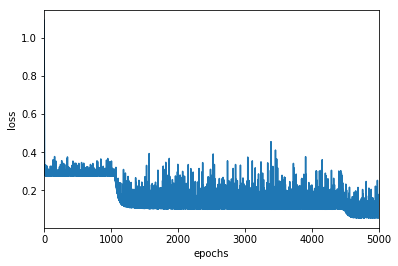

mse= 0.0008939455719501324


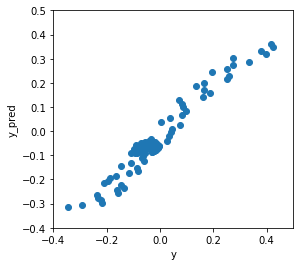

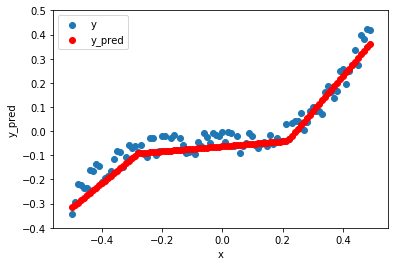

最終パラメーター
[[-1.3732e+00 -7.9000e-03  7.9000e-03 -8.8000e-03  7.9050e-01 -2.0000e-04
   8.0000e-04 -1.8453e+00 -9.5320e-01 -2.0000e-03]]
[ 0.6775 -0.0096 -0.0114 -0.0077  0.3862 -0.0096 -0.0013  0.3976 -0.2673
 -0.0049]
[[-8.800e-01]
 [ 1.820e-02]
 [-4.000e-04]
 [-1.440e-02]
 [ 3.226e-01]
 [-1.110e-02]
 [-1.330e-02]
 [ 7.368e-01]
 [-9.687e-01]
 [-8.900e-03]]
[0.1159]


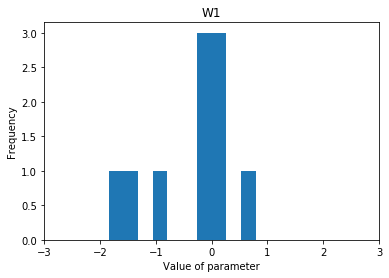

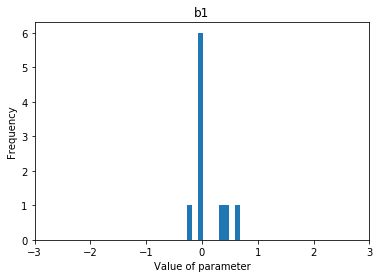

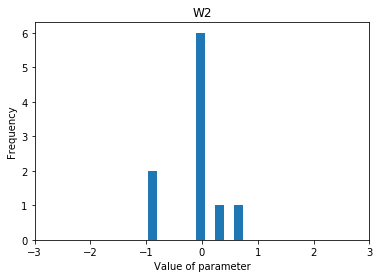

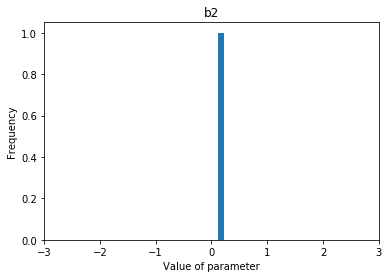

In [42]:
pram_ini ={}

np.random.seed(1111)
pram_ini["W1"] = 0.01 * np.random.randn(1, 10)
np.random.seed(1112)
pram_ini["b1"] = 0.01 * np.random.randn(10)
np.random.seed(1113)
pram_ini["W2"] = 0.01 * np.random.randn(10, 1)
np.random.seed(1114)
pram_ini["b2"] = 0.01 * np.random.randn(1)

run(x,y,pram_ini)


初期パラメータ
[[-0.013  -0.0107  0.0079 -0.0088  0.015  -0.0002  0.0028 -0.0097 -0.0158
  -0.002 ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-0.0098]
 [ 0.0187]
 [-0.0004]
 [-0.0144]
 [-0.0015]
 [-0.0111]
 [-0.0137]
 [ 0.001 ]
 [-0.0041]
 [-0.0089]]
[0.]


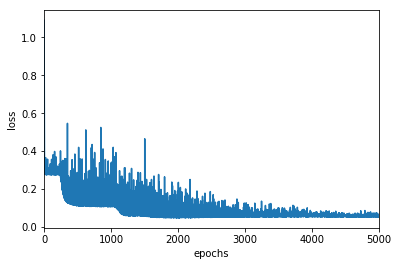

mse= 0.0005542967683435496


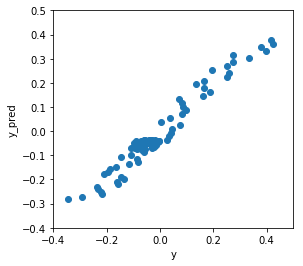

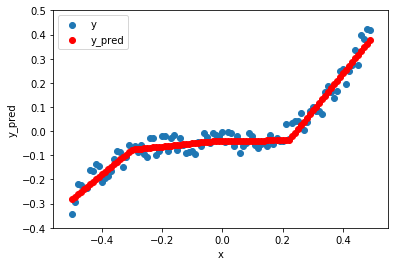

最終パラメーター
[[-1.1770e-01 -7.4000e-03  1.8296e+00 -9.1600e-02  1.9490e-01 -1.1260e-01
   1.1000e-03 -5.9300e-01 -2.6140e-01 -1.6423e+00]]
[-0.0029 -0.0091 -0.4021 -0.0024 -0.0252 -0.0597 -0.003  -0.0044 -0.0612
 -0.4943]
[[-0.0211]
 [ 0.0168]
 [ 0.8346]
 [-0.0121]
 [ 0.0557]
 [-0.0361]
 [-0.0134]
 [-0.2122]
 [-0.0381]
 [-0.5378]]
[-0.0388]


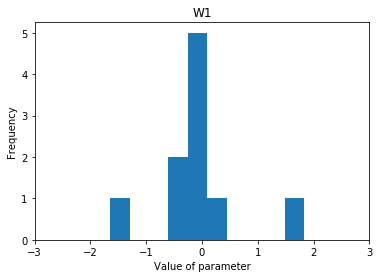

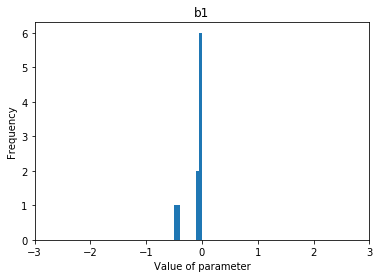

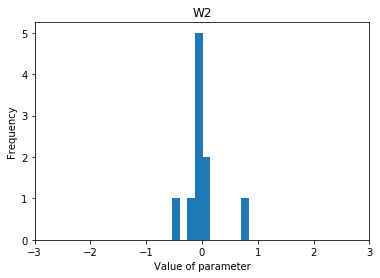

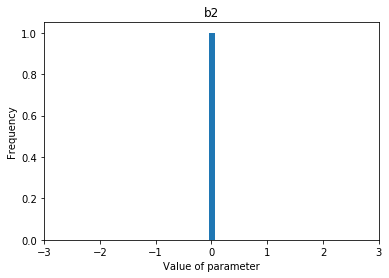

In [43]:
pram_ini ={}

np.random.seed(1111)
pram_ini["W1"] = 0.01 * np.random.randn(1, 10)
np.random.seed(1112)
pram_ini["b1"] = np.zeros(10)
np.random.seed(1113)
pram_ini["W2"] = 0.01 * np.random.randn(10, 1)
np.random.seed(1114)
pram_ini["b2"] = np.zeros(1)

run(x,y,pram_ini)